<a href="https://colab.research.google.com/github/annmarie520/DATASCI112/blob/main/Formula_1_Machine_Learning_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from numpy.random import choice
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, Normalizer, StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
import copy
from itertools import combinations
import csv

## Train/Test Data

In [4]:
df_f1 = pd.read_csv('/content/f1_data_with_float.csv')
df_f1 = df_f1.dropna()

In [5]:
train_idx = choice(len(df_f1), len(df_f1)//2, replace=False)
test_idx = np.delete(np.arange(len(df_f1)), train_idx)

In [6]:
df_train = df_f1.iloc[train_idx]
df_test = df_f1.iloc[test_idx]

## Variable Combinations

In [63]:
quantitative_variables = ["q1_float", "q2_float","q3_float","humidity_qualifying","rainfall_qualifying","humidity_race","rainfall_race","air_temp_qualifying","air_temp_race","wind_speed_qualifying","wind_speed_race","wind_direction_race","wind_direction_qualifying"]
categorical_variables = ["name_GP","name_team"]
y_train = df_train["fastest_lap_float"]

In [64]:
variable_combinations = []

for i in range(1, len(quantitative_variables)):
  combinations_at_index = list(combinations(quantitative_variables, i))
  for element in combinations_at_index:
    variable_combinations.append(list(element))

In [65]:
import copy
combination_rmse = pd.Series()
for variable_combination in variable_combinations:
  pre_processing = [(StandardScaler(), variable_combination),(OneHotEncoder(handle_unknown="ignore"), categorical_variables)]

  pipeline = make_pipeline(make_column_transformer(*pre_processing,remainder='passthrough'),KNeighborsRegressor(n_neighbors = 8, metric = "euclidean")) 
  
  train_features = copy.deepcopy(variable_combination)
  train_features.append(categorical_variables[0])
  train_features.append(categorical_variables[1])
  cross_val = -cross_val_score(pipeline, 
                              X=df_train[train_features],
                              y=y_train,
                              scoring="neg_mean_squared_error", cv=10)
  rmse_calc = np.sqrt(cross_val.mean())
  combination_rmse[str(variable_combination)] = rmse_calc

combination_rmse.sort_values()

<ipython-input-65-d09a28561981>:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  combination_rmse = pd.Series()


['q3_float', 'humidity_qualifying', 'rainfall_qualifying', 'air_temp_qualifying', 'air_temp_race', 'wind_direction_race']                                          0.137325
['q3_float', 'humidity_qualifying', 'air_temp_qualifying', 'air_temp_race', 'wind_direction_race']                                                                 0.137717
['q1_float', 'humidity_qualifying', 'rainfall_qualifying', 'air_temp_qualifying', 'air_temp_race']                                                                 0.137814
['q1_float', 'q2_float', 'humidity_qualifying', 'rainfall_qualifying', 'air_temp_race']                                                                            0.137844
['q2_float', 'humidity_qualifying', 'rainfall_qualifying', 'air_temp_qualifying', 'air_temp_race']                                                                 0.137847
                                                                                                                                            

Variables: 'q3_float', 'humidity_qualifying', 'rainfall_qualifying', 'air_temp_qualifying', 'air_temp_race', 'wind_direction_race' yields RMSE = 0.0137325 but with earlier testing I found that q1, q2, q3, humidity qualifying, humidity race, rainfall race, and rainfall qualifying yields the best test RMSE so I used those variables 

## Hyperparameter testing

In [21]:
pre_processing = [(StandardScaler(), ["q1_float", "q2_float", "q3_float","humidity_qualifying","rainfall_qualifying","humidity_race","rainfall_race"])]


x_train = df_train[["q1_float", "q2_float", "q3_float","humidity_qualifying","rainfall_qualifying","humidity_race","rainfall_race"]]
y_train = df_train["fastest_lap_float"]

pipeline = make_pipeline(
    make_column_transformer(
        *pre_processing,
        remainder='drop'),
    KNeighborsRegressor(n_neighbors = 20, metric = "euclidean")
)  

In [22]:
grid_search = GridSearchCV(pipeline,
                   param_grid={
                       "kneighborsregressor__n_neighbors": range(1, 20)
                       },
                   scoring="neg_mean_squared_error",
                   error_score='raise',
                   cv=5)

In [23]:
grid_search.fit(x_train, y_train)
grid_search.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['q1_float', 'q2_float',
                                                   'q3_float',
                                                   'humidity_qualifying',
                                                   'rainfall_qualifying',
                                                   'humidity_race',
                                                   'rainfall_race'])])),
                ('kneighborsregressor',
                 KNeighborsRegressor(metric='euclidean', n_neighbors=15))])

euclidean with n_neighbors=15 is best

In [26]:
x_train = df_train[["q1_float", "q2_float", "q3_float","humidity_qualifying","rainfall_qualifying","humidity_race","rainfall_race"]]
y_train = df_train["fastest_lap_float"]

def get_preprocessing(scaler):
  preprocessing = [(scaler, ["q1_float", "q2_float", "q3_float","humidity_qualifying","rainfall_qualifying","humidity_race","rainfall_race"])]
  return preprocessing 

for scaler in [StandardScaler(), MinMaxScaler()]:
  for metric in ["euclidean", "manhattan"]:
    pipeline = make_pipeline(make_column_transformer(*get_preprocessing(scaler)), 
                         KNeighborsRegressor(n_neighbors = 3, metric=metric))
    print(-1 * cross_val_score(pipeline, x_train, y_train, scoring="neg_mean_squared_error", cv=5).mean())

0.02224385978660318
0.023251925222560848
0.02222383886444445
0.023248124997058202


MinMaxScaler: euclidean is best

## RMSE Plot

Text(0, 0.5, 'RMSE')

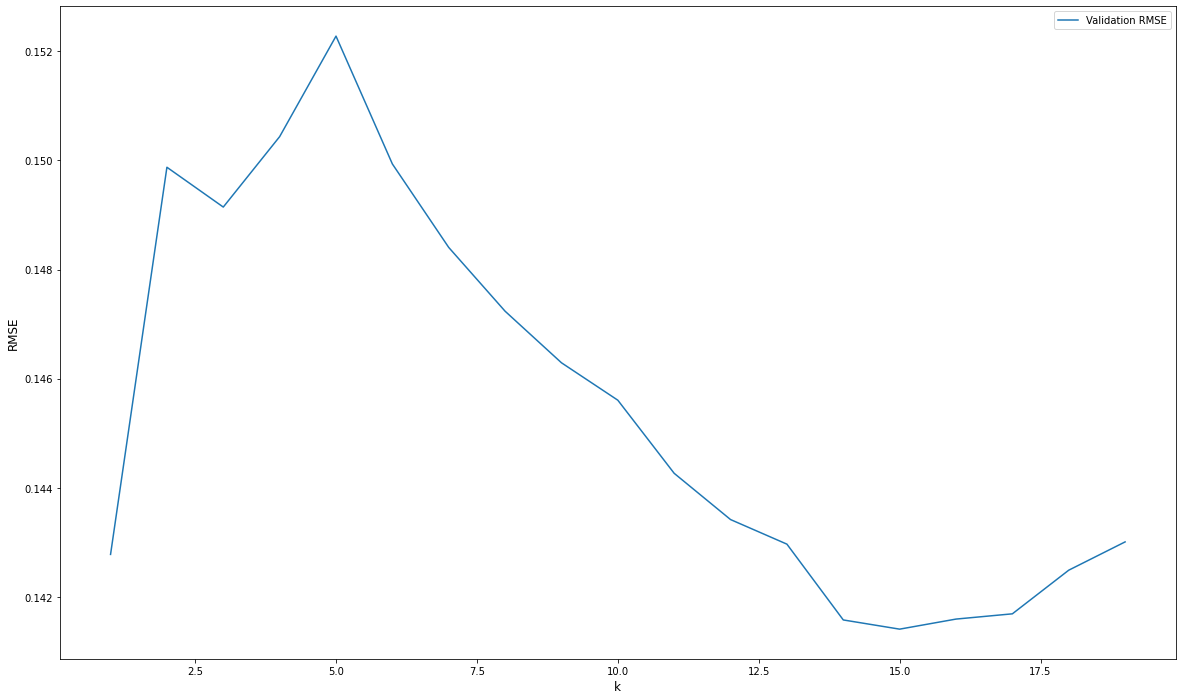

In [32]:
grid_search_results = grid_search.cv_results_
rmse_per_k = pd.Series(
            np.sqrt(grid_search_results["mean_test_score"]* -1),
            index=grid_search_results["param_kneighborsregressor__n_neighbors"]
            )

plt = rmse_per_k.plot.line(legend=True, label="Validation RMSE", figsize=(20, 12))
plt.set_xlabel("k", fontsize = 12)
plt.set_ylabel("RMSE", fontsize = 12)

## K-nearest neighbors test

In [53]:
#validation RMSE

x_train = df_train[["q1_float", "q2_float", "q3_float", "humidity_qualifying","rainfall_qualifying","humidity_race","rainfall_race"]]
y_train = df_train["fastest_lap_float"]

x_test = df_test[["q1_float", "q2_float", "q3_float", "humidity_qualifying","rainfall_qualifying","humidity_race","rainfall_race"]]
y_test = df_test["fastest_lap_float"]

model1 = make_pipeline(
    make_column_transformer(
        (MinMaxScaler(), ["humidity_qualifying"]), (MinMaxScaler(), ["rainfall_qualifying"]),
        (MinMaxScaler(), ["rainfall_race"]), (MinMaxScaler(), ["humidity_race"]),(MinMaxScaler(), ["q1_float"]),
        (MinMaxScaler(), ["q2_float"]),(MinMaxScaler(), ["q3_float"]),
        remainder='drop'),
    KNeighborsRegressor(n_neighbors = 15, metric = "euclidean")
)  

model1.fit(x_train,y_train)
y_train_predict = model1.predict(x_train)

print(-1 * cross_val_score(model1, x_train, y_train, scoring="neg_mean_squared_error", cv=5).mean())

0.020183098285318942


In [54]:
#test RMSE
x_train = df_train[["q1_float", "q2_float", "q3_float", "humidity_qualifying","rainfall_qualifying","humidity_race","rainfall_race"]]
y_train = df_train["fastest_lap_float"]

x_test = df_test[["q1_float", "q2_float", "q3_float", "humidity_qualifying","rainfall_qualifying","humidity_race","rainfall_race"]]
y_test = df_test["fastest_lap_float"]

model1 = make_pipeline(
    make_column_transformer(
        (MinMaxScaler(), ["humidity_qualifying"]), (MinMaxScaler(), ["rainfall_qualifying"]),
        (MinMaxScaler(), ["rainfall_race"]), (MinMaxScaler(), ["humidity_race"]),(MinMaxScaler(), ["q1_float"]),
        (MinMaxScaler(), ["q2_float"]),(MinMaxScaler(), ["q3_float"]),
        remainder='drop'),
    KNeighborsRegressor(n_neighbors = 15, metric = "euclidean")
)  

model1.fit(x_train,y_train)
y_test_predict = model1.predict(x_test)

print(np.sqrt(mean_squared_error(y_test, y_test_predict)))

0.03708017904287747


In [56]:
y_test_predict

array([1.358296  , 1.35674933, 1.358296  , 1.358296  , 1.35674933,
       1.358296  , 1.28518733, 1.25102933, 1.28550267, 1.25102933,
       1.28550267, 1.23338867, 1.23338867, 1.23338867, 1.23338867,
       1.23338867, 1.23338867, 1.23338867, 1.22451333, 1.22451333,
       1.23158667, 1.23158667, 1.23158667, 1.138482  , 1.138482  ,
       1.138482  , 1.138482  , 1.138482  , 1.394316  , 1.394316  ,
       1.394316  , 1.394316  , 1.394316  , 1.394316  , 1.3477    ,
       1.3477    , 1.3477    , 1.3477    , 1.3477    , 1.3477    ,
       1.15005067, 1.14902667, 1.14709333, 1.29566267, 1.29566267,
       1.30165933, 1.30165933, 1.28550267, 1.28518733, 1.28550267,
       1.28550267, 1.138482  , 1.138482  , 1.138482  , 1.138482  ,
       1.138482  , 1.26854467, 1.26854467, 1.26854467, 1.381958  ,
       1.381958  , 1.381958  , 1.381958  , 1.381958  , 1.381958  ,
       1.381958  , 1.381958  , 1.31881933, 1.31881933, 1.31084   ,
       1.31881933, 1.394316  , 1.394316  , 1.394316  , 1.39431

In [55]:
y_test

0      1.34932
1      1.34015
2      1.32090
5      1.34509
7      1.33228
        ...   
421    1.28723
422    1.26762
427    1.26419
436    1.27496
437    1.26615
Name: fastest_lap_float, Length: 102, dtype: float64

## Linear Regression test

In [ ]:
quantitative_variables = ["q1_float", "q2_float","q3_float","humidity_qualifying","rainfall_qualifying","humidity_race","rainfall_race","air_temp_qualifying","air_temp_race","wind_speed_qualifying","wind_speed_race","wind_direction_race","wind_direction_qualifying"]
categorical_variables = ["name_GP","name_team"]
y_train = df_train["fastest_lap_float"]

In [38]:
import copy
combination_rmse = pd.Series()
for variable_combination in variable_combinations:
  pre_processing = [(StandardScaler(), variable_combination),(OneHotEncoder(handle_unknown="ignore"), categorical_variables)]

  pipeline = make_pipeline(make_column_transformer(*pre_processing,remainder='passthrough'),LinearRegression()) 
  
  train_features = copy.deepcopy(variable_combination)
  train_features.append(categorical_variables[0])
  train_features.append(categorical_variables[1])
  cross_val = -cross_val_score(pipeline, 
                              X=df_train[train_features],
                              y=y_train,
                              scoring="neg_mean_squared_error", cv=10)
  rmse_calc = np.sqrt(cross_val.mean())
  combination_rmse[str(variable_combination)] = rmse_calc

combination_rmse.sort_values()

<ipython-input-38-9035a0ee0947>:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  combination_rmse = pd.Series()


['q3_float', 'humidity_qualifying', 'rainfall_qualifying', 'humidity_race', 'rainfall_race']    0.008025
['q3_float', 'humidity_qualifying', 'rainfall_qualifying']                                      0.008025
['q3_float', 'humidity_race', 'rainfall_race']                                                  0.008025
['q3_float', 'humidity_qualifying', 'rainfall_qualifying', 'rainfall_race']                     0.008025
['q3_float', 'humidity_qualifying', 'humidity_race']                                            0.008025
                                                                                                  ...   
['q1_float', 'q2_float', 'rainfall_race']                                                       0.008995
['q1_float', 'q2_float', 'rainfall_qualifying', 'humidity_race', 'rainfall_race']               0.008995
['q1_float', 'q2_float', 'humidity_qualifying', 'rainfall_qualifying', 'rainfall_race']         0.008995
['q1_float', 'q2_float', 'humidity_race', 'rainfall_rac

q3, rainfall race, rainfall qualifying, humidity race, and hunmidity qualifying yield the highest RMSE = 0.008025 but I added in q1 and q2 based on data exploration findings high correlation with fastest lap time

In [37]:
#validation RMSE

from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score

pre_processing = [(MinMaxScaler(), ["q1_float", "q2_float", "q3_float","humidity_qualifying","rainfall_race", "humidity_race", "rainfall_qualifying"])]

x_train = df_train[["q1_float", "q2_float", "q3_float", "humidity_qualifying","rainfall_race", "humidity_race","rainfall_qualifying"]]
y_train = df_train["fastest_lap_float"]

model2 = make_pipeline(
    make_column_transformer(
        *pre_processing,
        remainder='drop'),
    LinearRegression()
) 

neg_mse = cross_val_score(
    model2, x_train, y_train,scoring="neg_mean_squared_error", cv=10
)
print(-neg_mse.mean())

0.021864026406596872


In [38]:
#test RMSE

from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score

pre_processing = [(MinMaxScaler(), ["q1_float", "q2_float", "q3_float","humidity_qualifying","rainfall_race", "humidity_race", "rainfall_qualifying"])]

x_train = df_train[["q1_float", "q2_float", "q3_float", "humidity_qualifying","rainfall_race", "humidity_race","rainfall_qualifying"]]
y_train = df_train["fastest_lap_float"]

x_test = df_test[["q1_float", "q2_float", "q3_float", "humidity_qualifying","rainfall_race", "humidity_race","rainfall_qualifying"]]
y_test = df_test["fastest_lap_float"]

model2 = make_pipeline(
    make_column_transformer(
        *pre_processing,
        remainder='drop'),
    LinearRegression()
) 

model2.fit(x_train,y_train)
y_test_predict = model2.predict(x_test)

print(np.sqrt(mean_squared_error(y_test, y_test_predict)))



0.08800855265837021


## Ensemble Model

In [39]:
pre_processing = [(MinMaxScaler(), ["q1_float", "q2_float", "q3_float","humidity_qualifying","rainfall_race", "humidity_race", "rainfall_qualifying"])]

x_train = df_train[["q1_float", "q2_float", "q3_float", "humidity_qualifying","rainfall_race", "humidity_race", "rainfall_qualifying"]]
y_train = df_train["fastest_lap_float"]

model2 = make_pipeline(
    make_column_transformer(
        *pre_processing,
        remainder='drop'),
    LinearRegression()
) 

# estimating test error
neg_mse = cross_val_score(
    model2, x_train, y_train,scoring="neg_mean_squared_error", cv=10
)
print(-neg_mse.mean())

0.021864026406596872


In [41]:
x_train = df_train[["q1_float", "q2_float", "q3_float", "humidity_qualifying","rainfall_qualifying","humidity_race","rainfall_race"]]
y_train = df_train["fastest_lap_float"]

x_test = df_test[["q1_float", "q2_float", "q3_float", "humidity_qualifying","rainfall_qualifying","humidity_race","rainfall_race"]]
y_test = df_test["fastest_lap_float"]

model1 = make_pipeline(
    make_column_transformer(
        (MinMaxScaler(), ["humidity_qualifying"]), (MinMaxScaler(), ["rainfall_qualifying"]),
        (MinMaxScaler(), ["rainfall_race"]), (MinMaxScaler(), ["humidity_race"]),(MinMaxScaler(), ["q1_float"]),
        (MinMaxScaler(), ["q2_float"]),(MinMaxScaler(), ["q3_float"]),
        remainder='drop'),
    KNeighborsRegressor(n_neighbors = 15, metric = "euclidean")
)  

model1.fit(x_train,y_train)
y_test_predict = model1.predict(x_test)

print(-1 * cross_val_score(model1, x_train, y_train, scoring="neg_mean_squared_error", cv=5).mean())


0.020183098285318942


In [44]:
# original model
[-cross_val_score(model, x_train, y_train,scoring="neg_mean_squared_error",cv=4).mean() for model in [model1, model2]]

[0.020263709328529746, 0.023176114402052434]

In [45]:
#voting model
from sklearn.ensemble import VotingRegressor
voter = VotingRegressor([("Model 1", model1), ("Model 2", model2)])
print(-1 * cross_val_score(voter, x_train, y_train, scoring="neg_mean_squared_error", cv=5).mean())

0.02062239838143961


In [ ]:
model1.fit(X=x_train, y=y_train)
model2.fit(X=x_train, y=y_train)
(model1.predict(x_test) + model2.predict(x_test)) / 2

In [47]:
#stacking model
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
stacker = StackingRegressor([("Model 1", model1), ("Model 2", model2)], final_estimator=LinearRegression())
print(-1 * cross_val_score(stacker, x_train, y_train, scoring="neg_mean_squared_error", cv=5).mean())

0.021011837886708823


In [49]:
#voting model predictions
voter = VotingRegressor([("Model 1", model1), ("Model 2", model2)])
voter.fit(x_train,y_train)
y_test_predict = voter.predict(x_test)
print(np.sqrt(mean_squared_error(y_test, y_test_predict)))



0.05486751751172725


In [52]:
#stacker model predictions
stacker = StackingRegressor([("Model 1", model1), ("Model 2", model2)])
stacker.fit(x_train, y_train)
y_test_predict = stacker.predict(x_test)
print(np.sqrt(mean_squared_error(y_test, y_test_predict)))

0.04632904291365646


# Results

## Knearest Neighbor Model



*  Variables:qualifying 1, qualifying 2, qualifying 3, qualifying rainfall,qualifying humidity, qualilfying race, and race rainfall
*  Optimal K = 15
*  MinMaxScaler with euclidean
*  Validation RMSE = 0.020183098285318942
*  Test RMSE = 0.03708017904287747






## Linear Regression Model

*  Variables: qualifying 1, qualifying 2, qualifying 3, qualifying humidity, qualifying rainfall, race humidity, and race rainfall
*  Validation RMSE =  0.021864026406596872
*  Test RMSE = 0.08800855265837021

## Ensemble Model

**Voting Model**
*  Variables: qualifying 1, qualifying 2, qualifying 3, qualifying humidity, qualifying rainfall, race humidity, and race rainfall
*  Validation RMSE = 0.02062239838143961
*  Test RMSE =  0.05486751751172725

**Stacking Model**
*  Variables: qualifying 1, qualifying 2, qualifying 3, qualifying humidity, qualifying rainfall, race humidity, and race rainfall
*  Validation RMSE = 0.021011837886708823
*  Test RMSE = 0.04632904291365646  